# Subject Video Rating Correlations

## Data management and cleaning

In [86]:
import pandas as pd
import numpy as np
import os
import scipy
import scipy.io as sio
import itertools

from string import ascii_letters
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline  

In [87]:
def half_integer_round(number): return round(number * 2) / 2
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [88]:
project_filepath = "/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/"

project_file_contents = os.listdir(project_filepath)

project_file_contents_mat = [item for item in project_file_contents if ".mat" in item]


#Get unique subject IDs (first three numbers of filename)
unique_sub_ids = [item for item in project_file_contents if 'video' in item]
unique_sub_ids = set([str.split(file, "_")[0] for file in unique_sub_ids])

unique_sub_ids = ['229', '223', '146', '242', '179', '186', '138', '145', '157', '161', '163', '214', '236', '245', '288',  '231', '196', '184', '220', '239', '195', '282', '177', '266', '160', '197', '208', '173', '216', '156', '200', '256', '167', '222', '279', '237', '263', '168', '280', '147', '165', '277', '278', '253', '188', '289', '162', '262', '276', '267', '139', '219', '260', '215', '257',  '154', '251', '274', '270']
unique_sub_ids.sort(key=float)

## Functions for Calcuating Correlations and Plotting

In [89]:
#Load and Concatenate all ref files

def create_ref_file(sub_id, project_file_contents):
    ref_file_contents = [item for item in project_file_contents_mat if "intfMRI" + str(sub_id) in item]
    ref_file_data = []
    for file in ref_file_contents: 
        mat_contents = sio.loadmat(project_filepath + file)
        ref_file_data.append(pd.DataFrame(mat_contents['data']))
    
    #Join all files and remove empty data and irrelevant columns
    ref_file_data = pd.concat(ref_file_data)
    ref_file_data = ref_file_data[ref_file_data[5] != 0]
    ref_file_data = ref_file_data[ref_file_data[6] != 0]
    ref_file_data = ref_file_data.loc[:,0:4]
    
    ref_file_data.columns = ["sub_id", "trial", "video_number", "self_other", "neg_pos"]
    
    #Remove duplicate trials
    ref_file_data = ref_file_data.drop_duplicates("trial")
    
    #Recode neg pos and self_other
    ref_file_data['self_other'][ref_file_data['self_other'] == 1] = "self"
    ref_file_data['self_other'][ref_file_data['self_other'] == 2] = "other"
    ref_file_data['neg_pos'][ref_file_data['neg_pos'] == 1] = "neg"
    ref_file_data['neg_pos'][ref_file_data['neg_pos'] == 2] = "pos"
    
    return ref_file_data


In [90]:
# Create data frame that has all video data (per subject)

def get_video_data(sub_id, video):
    project_file_contents = os.listdir(project_filepath)
    sub_video_filenames = [item for item in project_file_contents if str(sub_id)  in item]
    sub_video_filenames = [item for item in sub_video_filenames if 'video' + str(video) + '.csv'  in item]    
    sub_video_data = []
    file = sub_video_filenames[0]


    csv_contents = pd.read_csv(project_filepath + file)
    video_data = pd.DataFrame(csv_contents)
    video_data.columns = ['second', 'rating']
    video_data['subject'] = str.split(file, "_")[0]
    video_data['video_number'] = int(float(str.split(file, "_")[2].replace('.csv', '').replace('video', '')))
    video_data['second'] = video_data['second'].apply(lambda x: half_integer_round(x))

    #ref_data = create_ref_file(sub_id, project_file_contents)
    #all_videos = pd.merge(sub_video_data, ref_data, on='video_number', how='left')
    #video_data = all_videos[all_videos['video_number'] == video]
    video_data = video_data[video_data['second'] != 0]

    return(video_data[['second','rating']])
    



In [91]:
#Plots correlations heatmap matrix

def plot_corrs(all_video_data, video):
    
    sns.set(style="white")

    # Compute the correlation matrix
    all_video_data = all_video_data.drop('second', 1) #Drop seconds for correlation
    corr = all_video_data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,  cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    averge_z_correlation = calculate_aver_correlation(all_video_data)

    plt.title('Video: ' + str(video) + " , Correlation (z) " + str(averge_z_correlation))

In [92]:
#Calculate average correlation (z)

def calculate_aver_correlation(all_video_data): 
    unique_sub_ids = list(all_video_data)
    combinations = pd.DataFrame(list(itertools.combinations(unique_sub_ids, 2)))
    corr = all_video_data.corr()

    df = []
    for index, row in combinations.iterrows():
        df.append([row[0], row[1], corr[row[0]][row[1]]])


    df = pd.DataFrame(df)
    df.columns = ['sub1', 'sub2', 'corr']


    
    df['z'] = 0.5*np.log((1+df['corr'])/(1-df['corr']))
    df['z'] = pd.to_numeric(df['z'], errors='coerce')

    df = df.replace([np.inf, -np.inf], np.nan)
    return(df['z'].mean())



In [93]:
plt.close('all')


In [94]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Create and Save Correlations

In [95]:
# ##Calculate everything for all subject data

# z_correlations = []
# for video in range(1, 17): 
    
#     #Get video length and make array of each half second
#     video_length = get_video_data(unique_sub_ids[0], video)['second'].max()
#     all_video_data = pd.DataFrame({'second': list(frange(0, video_length, 0.5))})
    
#     #Compile all subjects video data
#     for sub_id in unique_sub_ids: 
        
#         try: 
#             #Get subject data and merge to column
#             subject_data = get_video_data(sub_id, video)
#             subject_data = subject_data.rename(columns ={'rating': sub_id})
#             all_video_data = pd.merge(all_video_data, subject_data , on='second', how='outer')
#             all_video_data = all_video_data[all_video_data['second'] != 0] #Remove data after scan is over
#             #all_video_data = all_video_data.fillna(method='pad', limit =1) #fill forward for any NAs, shouldn't be a problem for correlations

#         except Exception:
#             pass
#     #Add to z correlations list

#     all_video_data.to_csv(project_filepath + 'video_all_' + str(video) + '.csv', index=False)
#     z_correlations.append([video, calculate_aver_correlation(all_video_data)])


# Plot Correlations

##     Video Target Rating and Avearge Participant Ratings

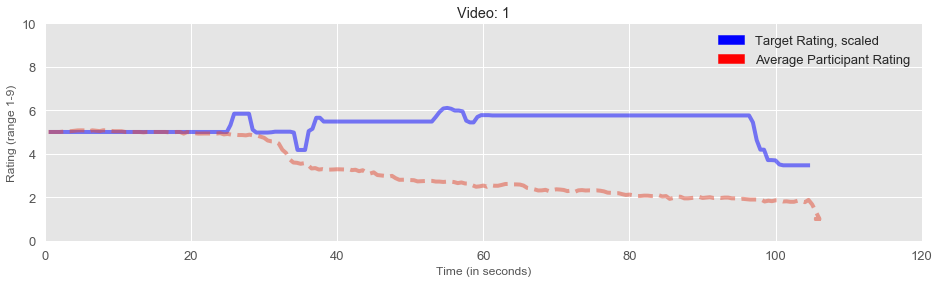

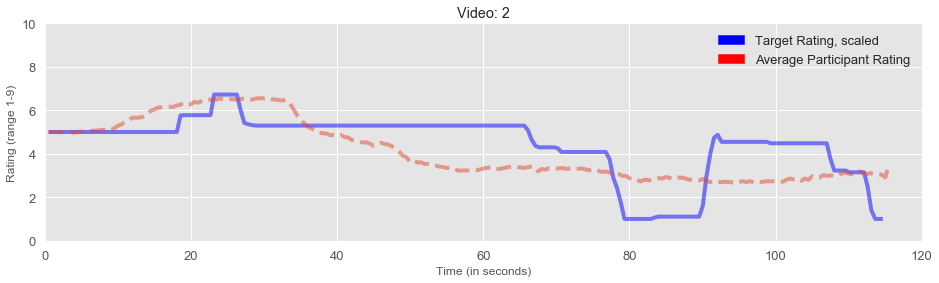

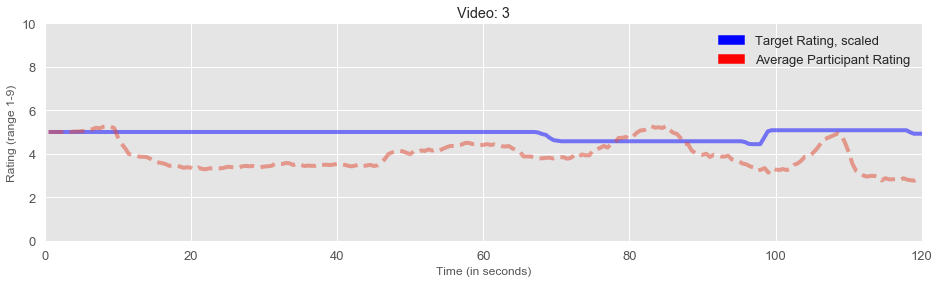

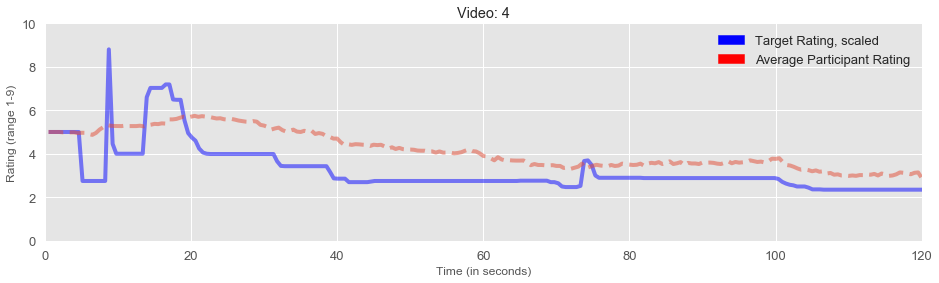

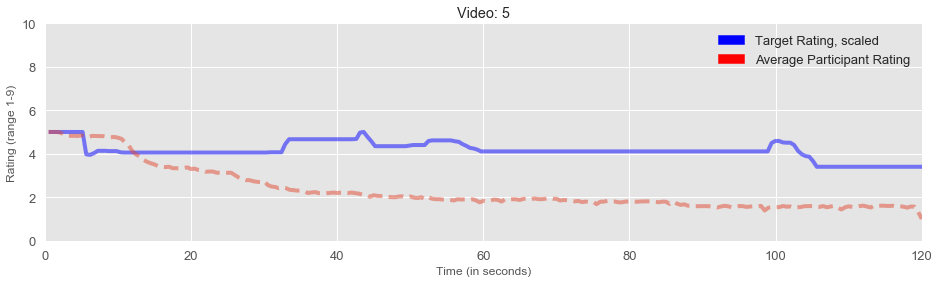

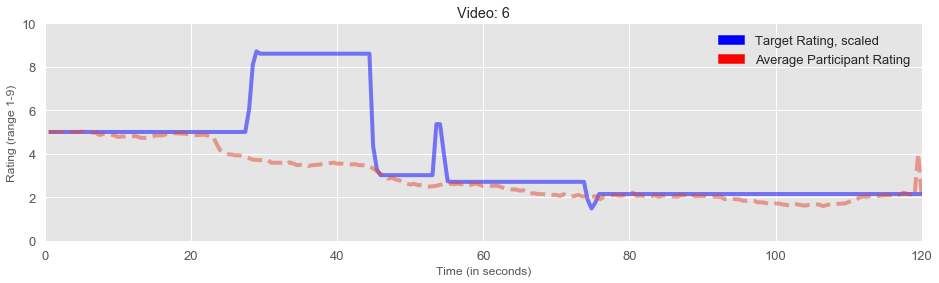

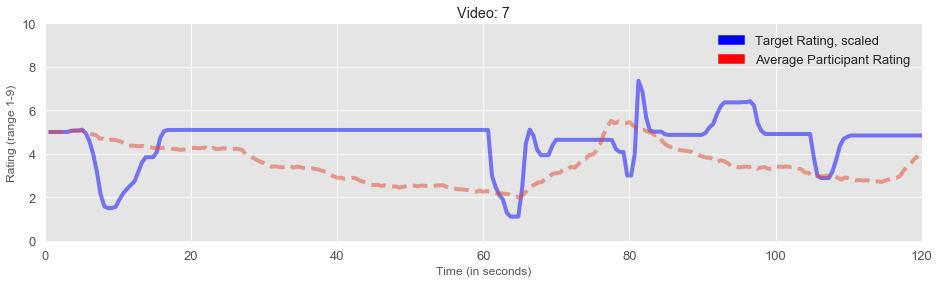

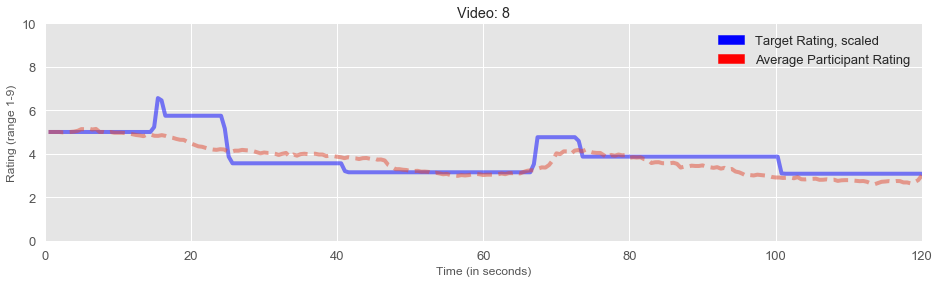

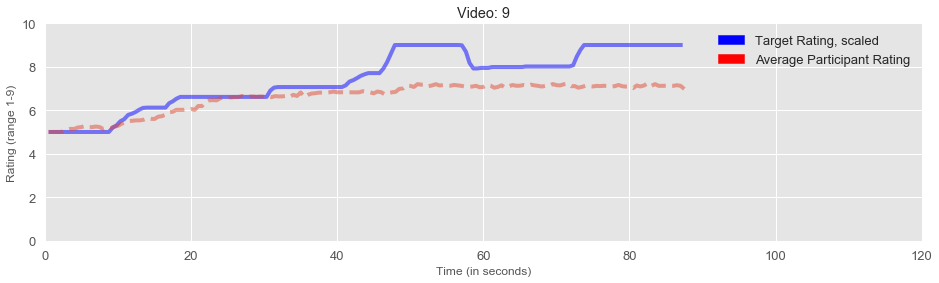

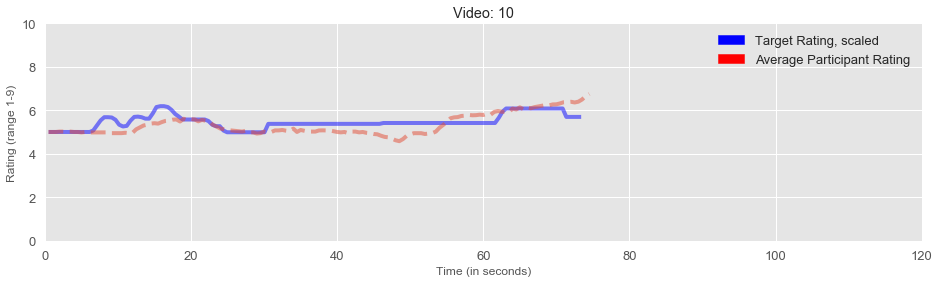

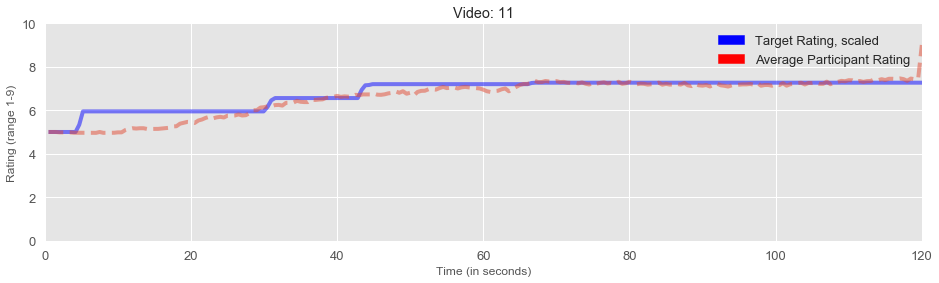

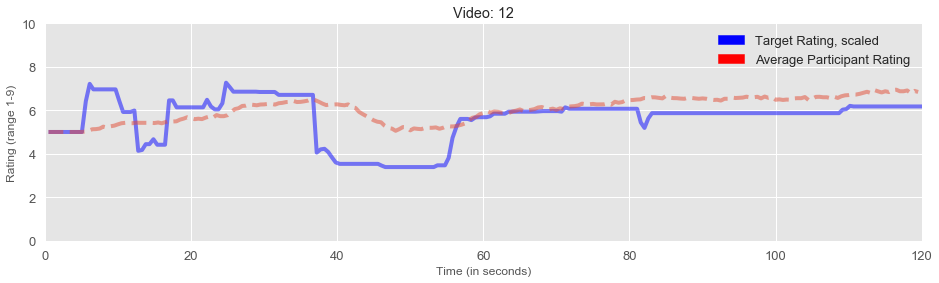

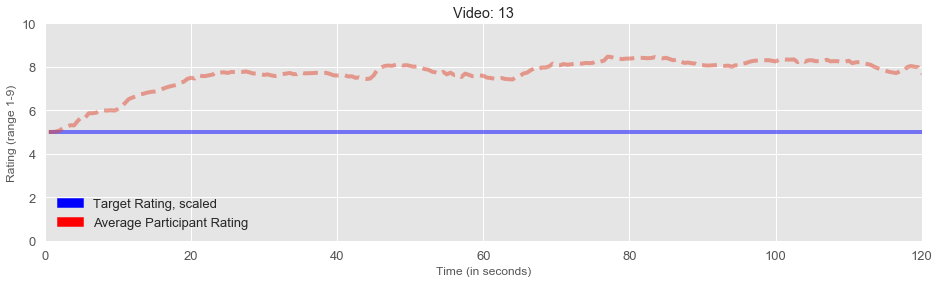

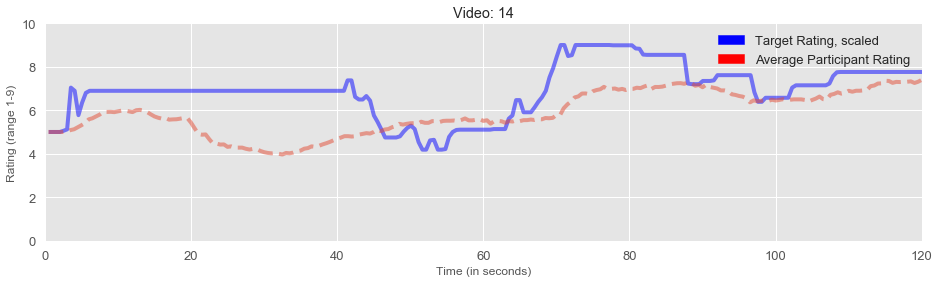

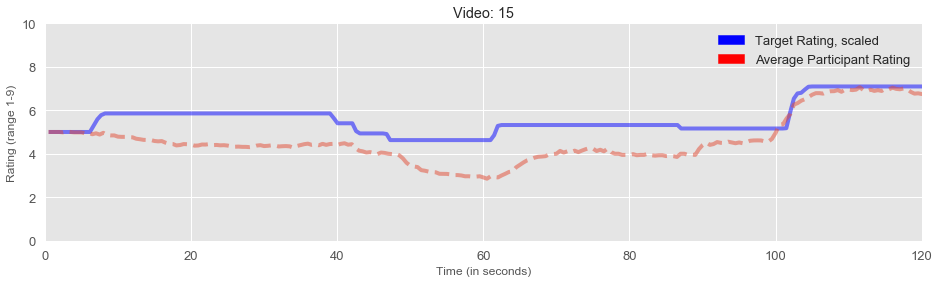

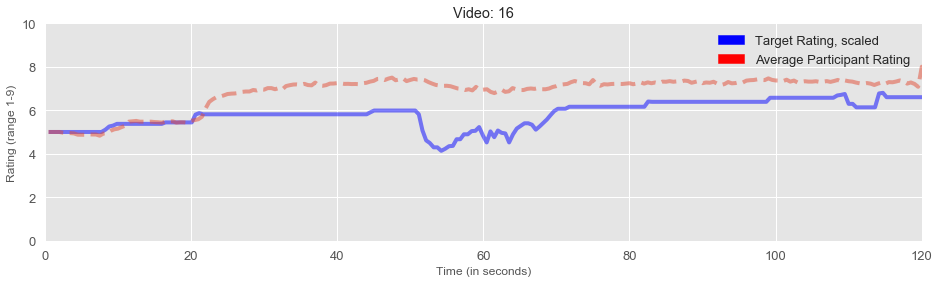

In [96]:
for video in range(1, 17): 
    all_video_data = pd.read_csv(project_filepath + 'video_all_' + str(video) + '.csv')
    target_data = pd.read_csv(project_filepath + '100_01_video' + str(video) + '.csv')

    target_data['rating_scaled'] = (((target_data[' rating'] - 0) * (9 - 1)) / (100 - 0)) + 1


    # Plot target
    
    x = target_data['time']
    y = target_data['rating_scaled']
    
    plt.figure(figsize=(14,4))

    plt.title("Video: " + str(video))
    plt.ylim(0,10)
    plt.ylabel('Rating (range 1-9)')
    plt.xlim(0,120)
    plt.xlabel('Time (in seconds)')

    legend_blue = mpatches.Patch(color='blue', label='Target Rating, scaled')
    plt.plot(x, y,'b', alpha=.5);
    
    
    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1).mean(axis=1)
    #plt.figure(figsize=(14,4))
    #plt.ylim(0,10)
    
    legend_red = mpatches.Patch(color='red', label='Average Participant Rating')
    plt.legend(handles=[legend_blue, legend_red])    
    
    plt.plot(x, y, '--', alpha=.5);
    

## Matrix Plots of Participant Ratings and Time Course of Ratings

/Users/mdclark/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


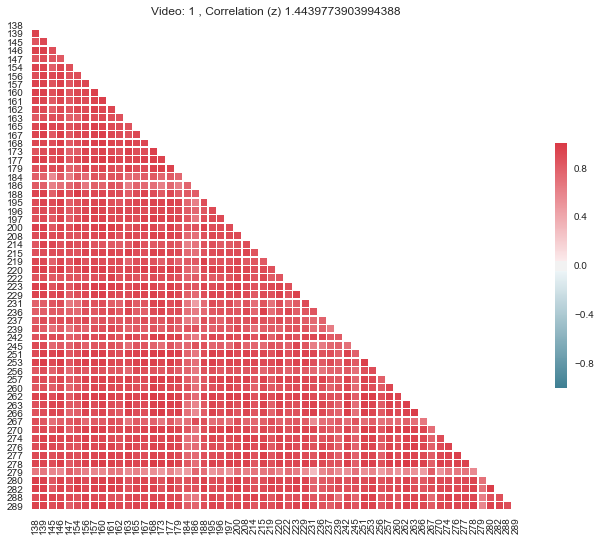

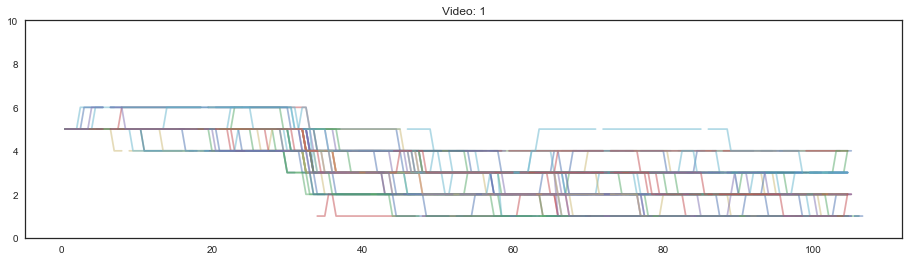

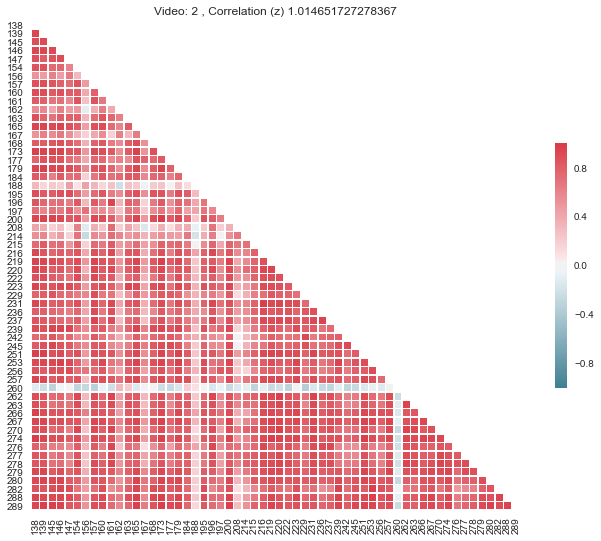

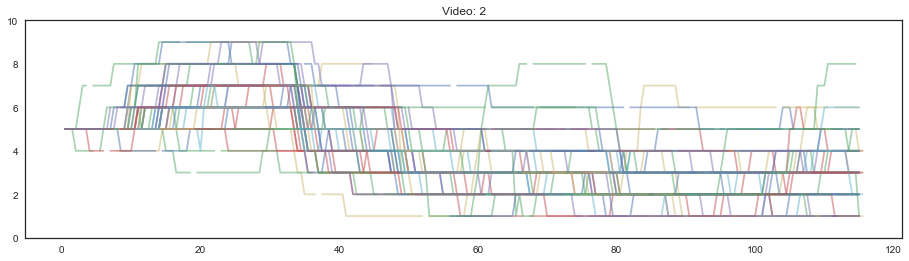

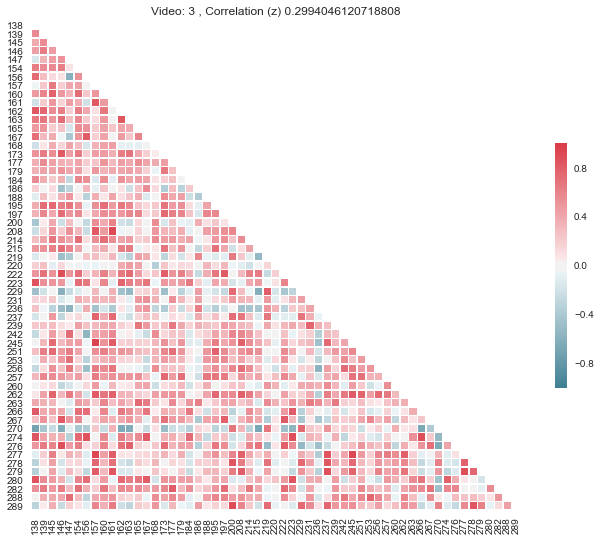

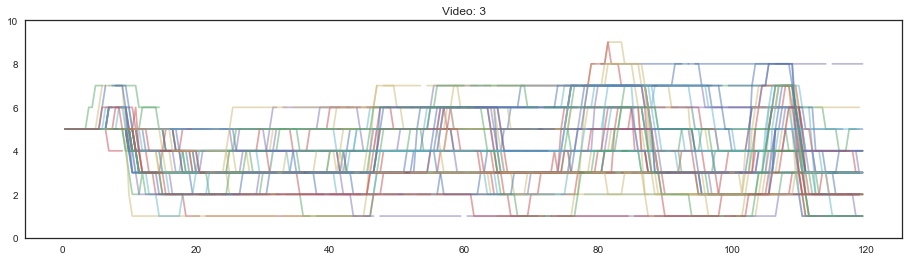

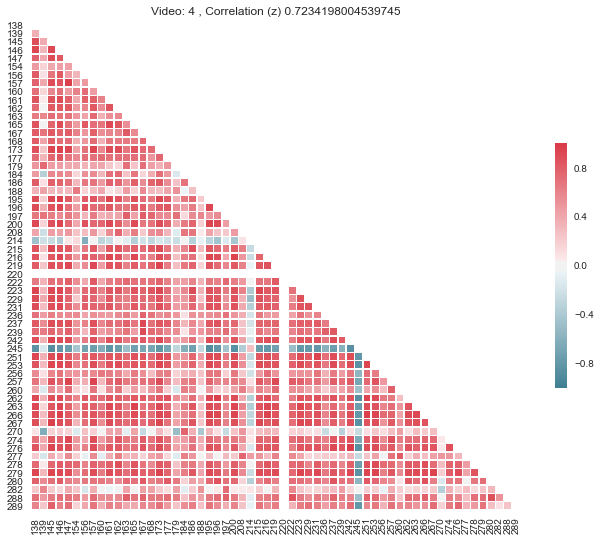

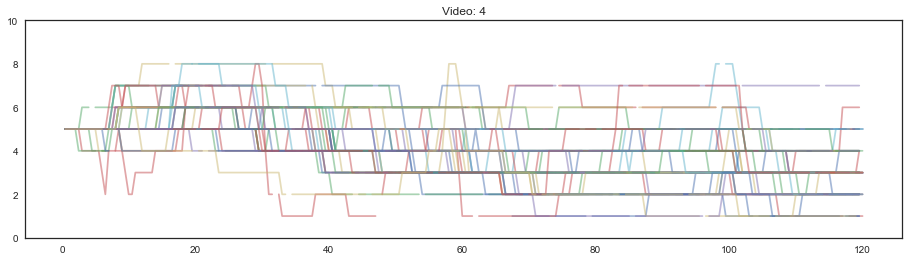

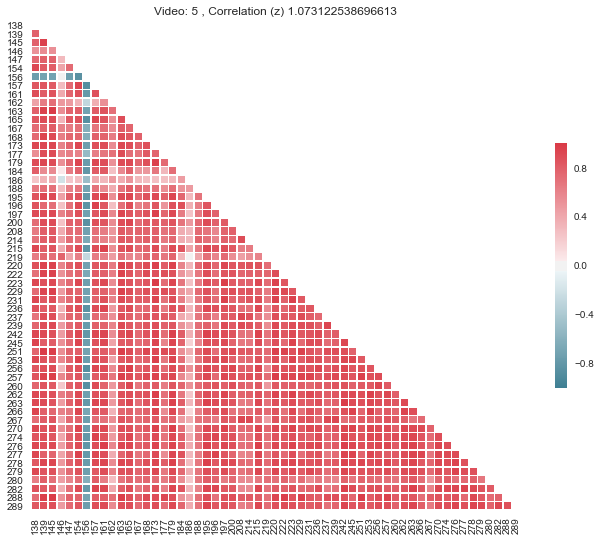

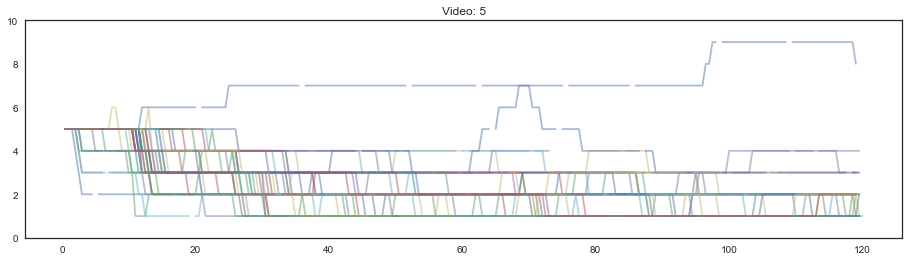

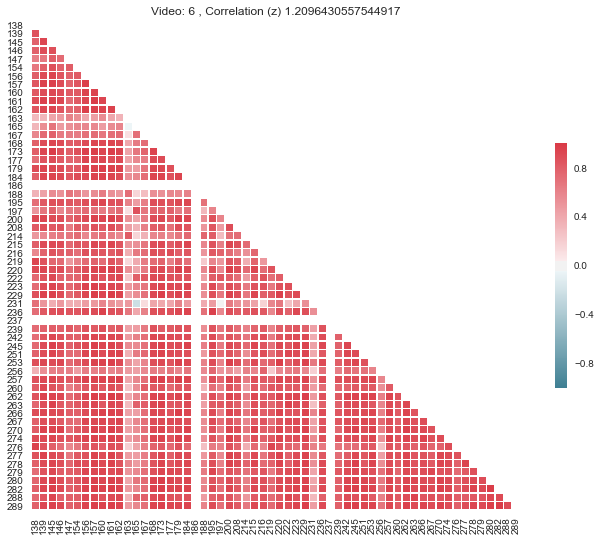

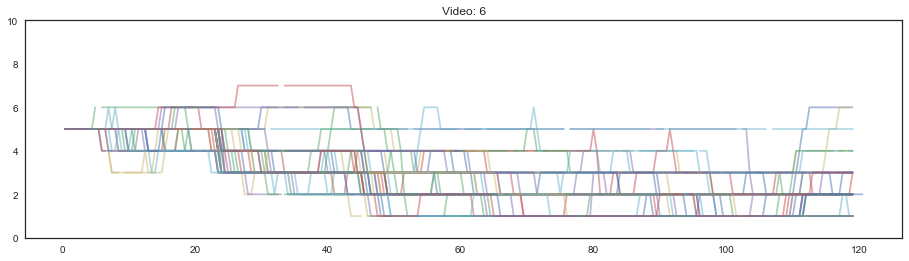

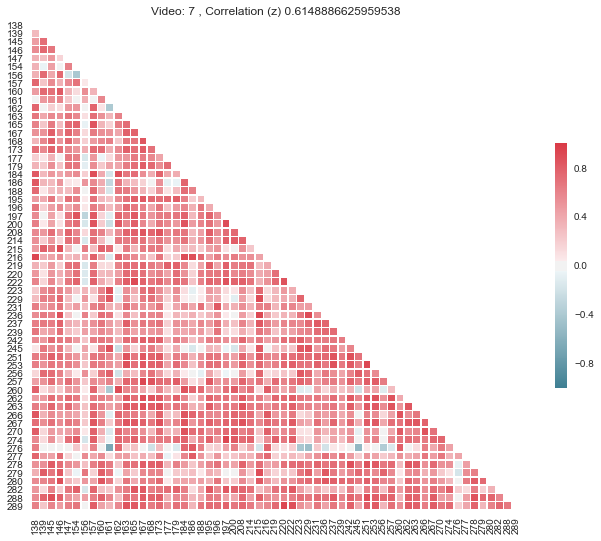

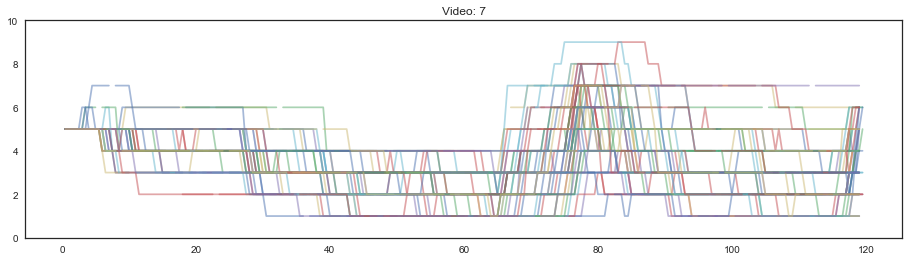

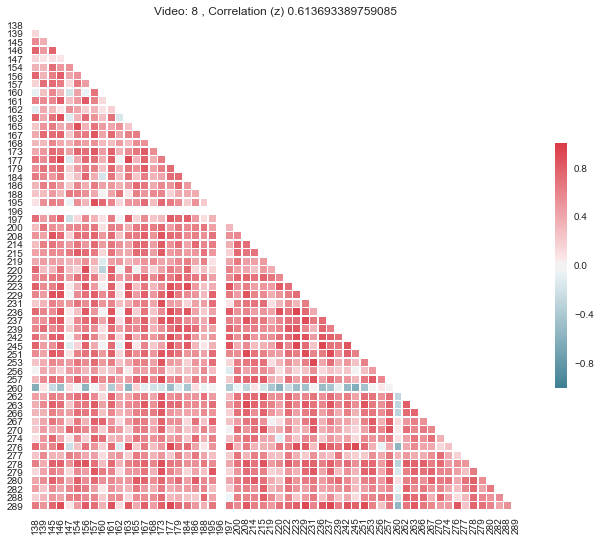

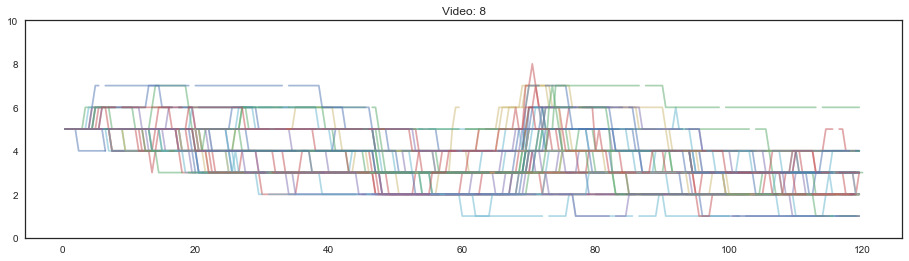

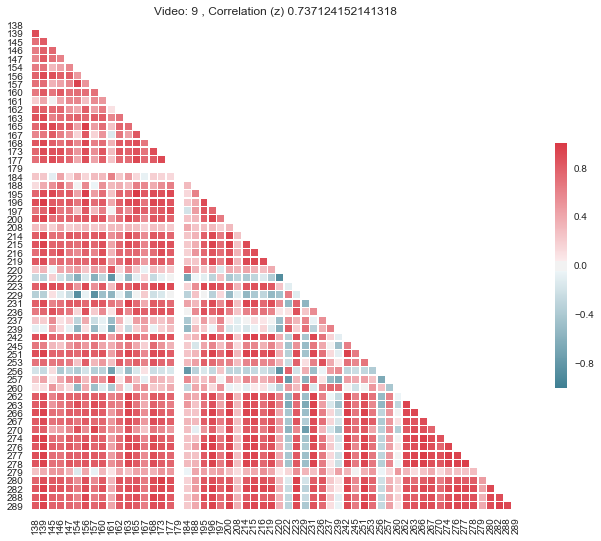

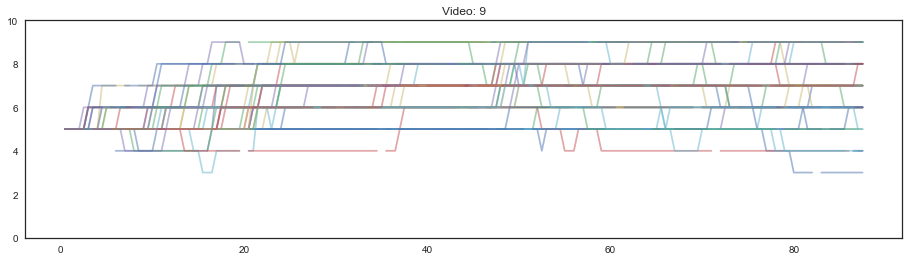

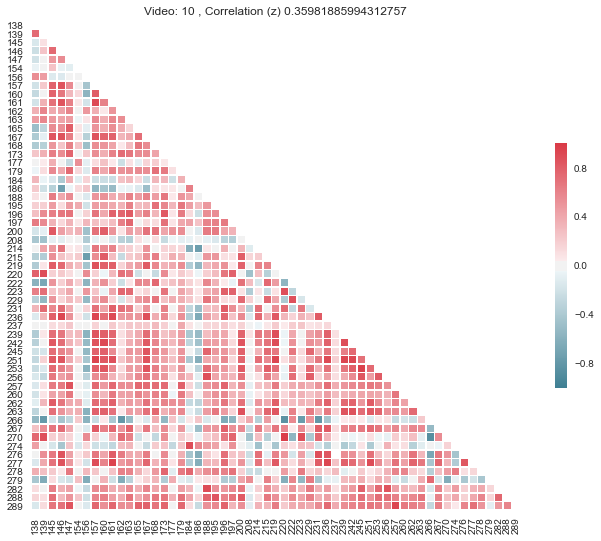

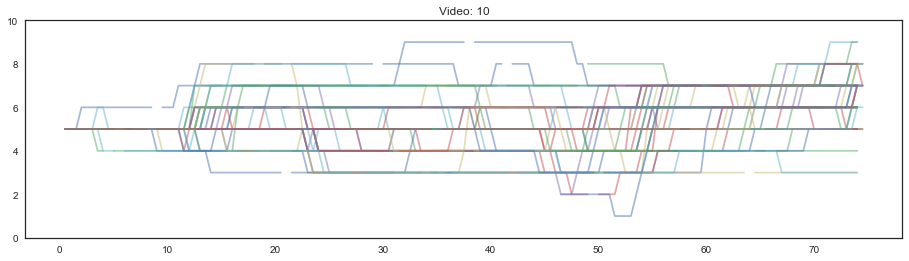

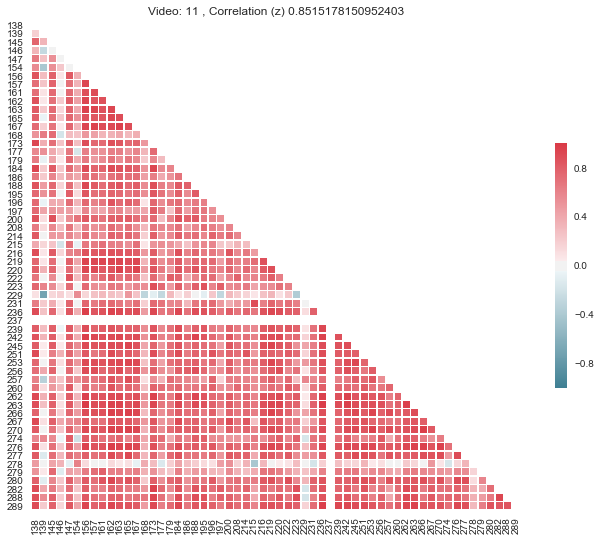

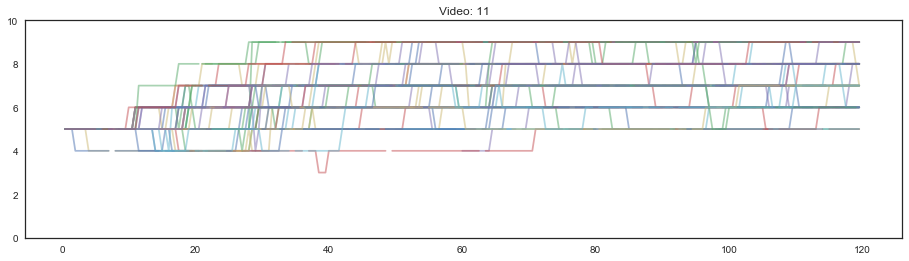

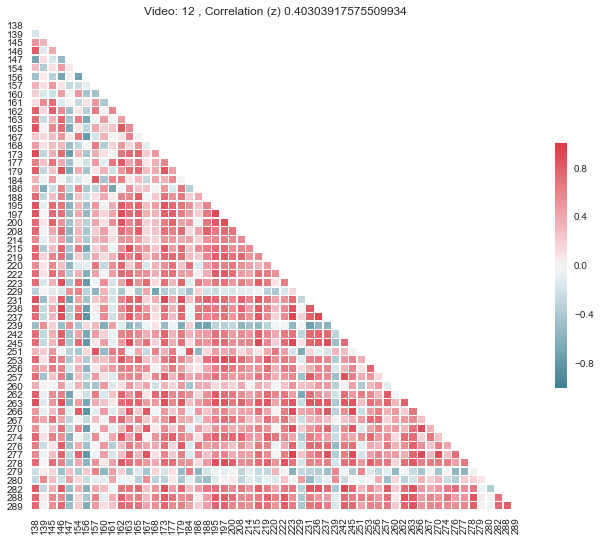

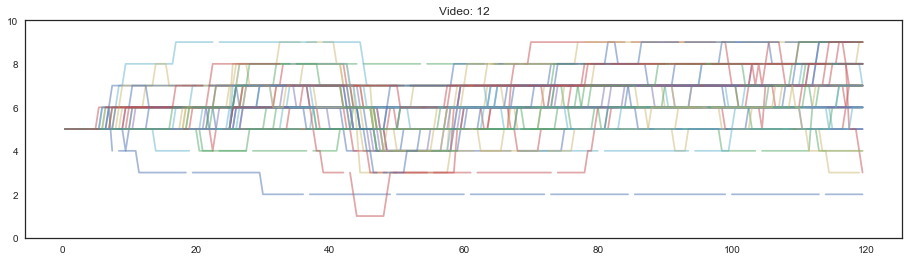

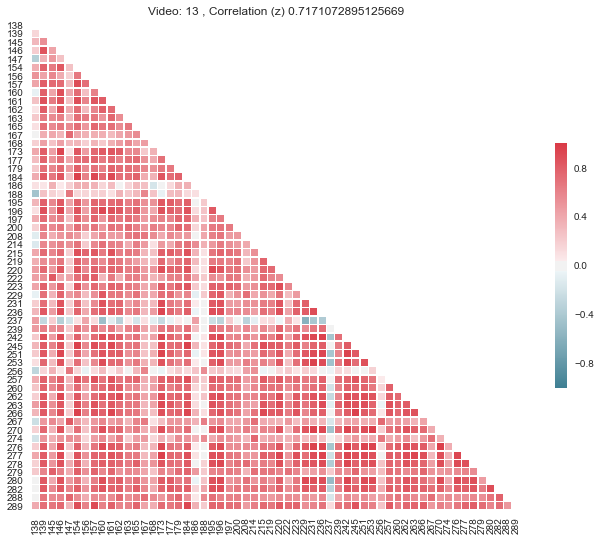

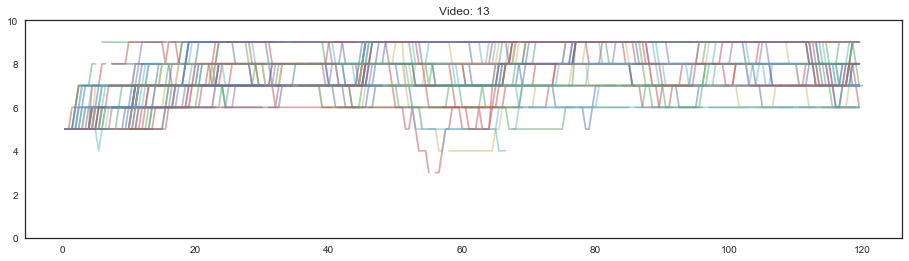

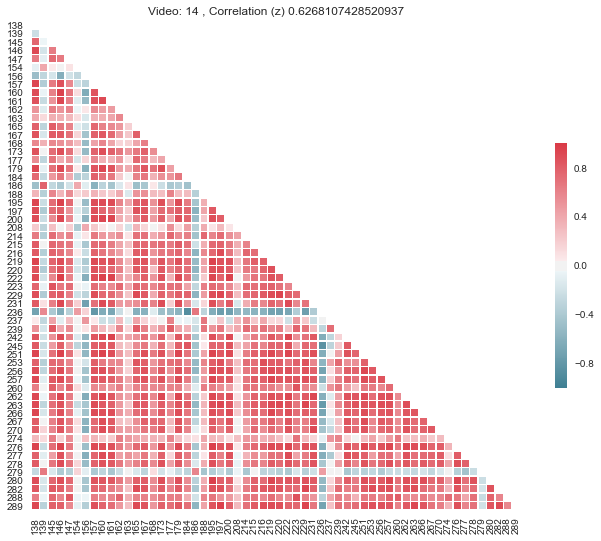

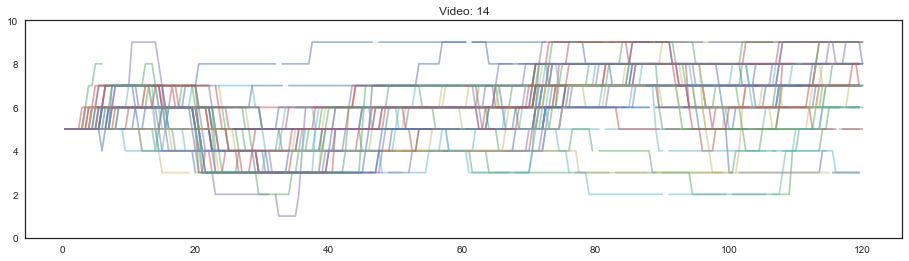

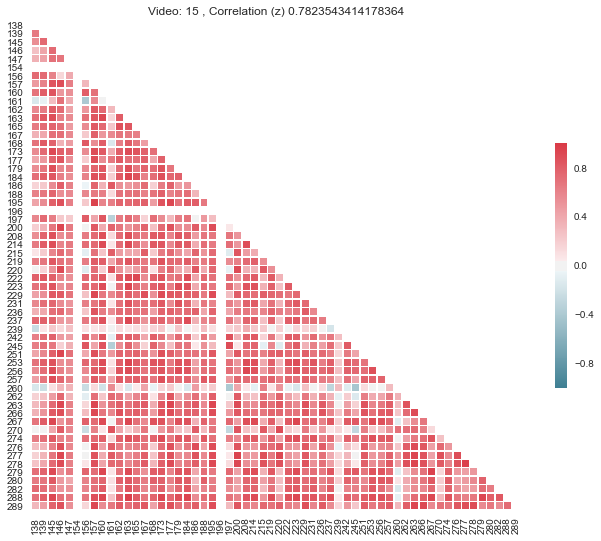

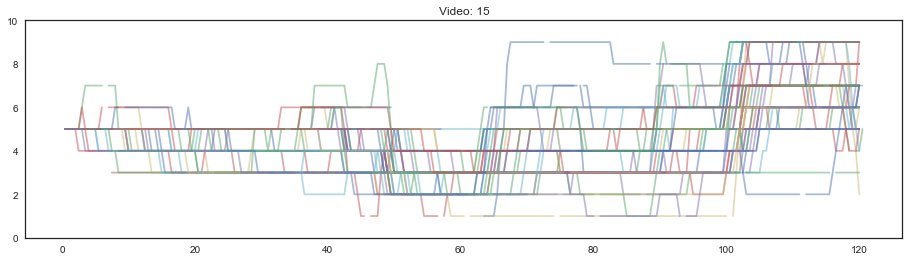

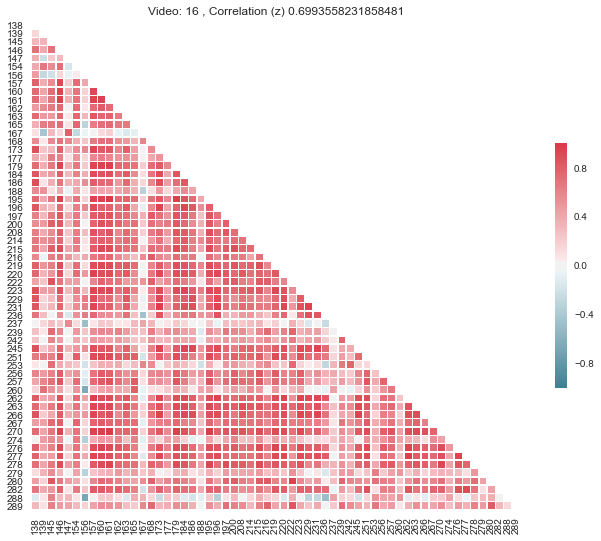

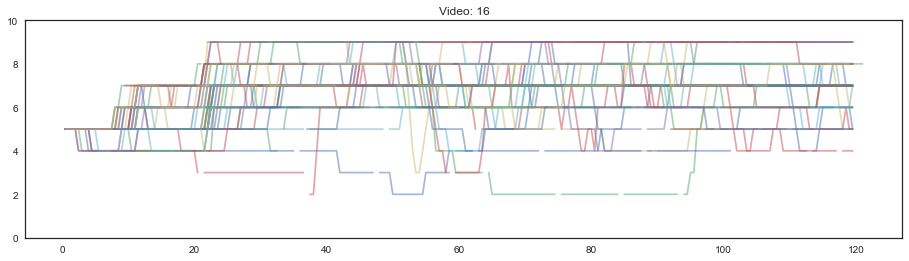

In [101]:
z_correlations = []
for video in range(1, 17): 
    all_video_data = pd.read_csv(project_filepath + 'video_all_' + str(video) + '.csv')
    all_video_data_dropped = all_video_data.drop(['second'], axis=1)
    z_correlations.append([video, calculate_aver_correlation(all_video_data_dropped)])

    
    calculate_aver_correlation(all_video_data_dropped)
        
    # Plot correlations
    plot_corrs(all_video_data, video)
    
    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1)
    plt.figure(figsize=(14,4))
    plt.ylim(0,10)
    plt.title('Video: ' + str(video))
    plt.plot(x, y, alpha=.5);


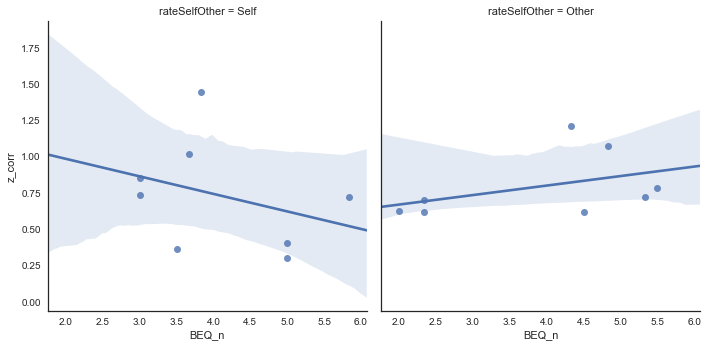

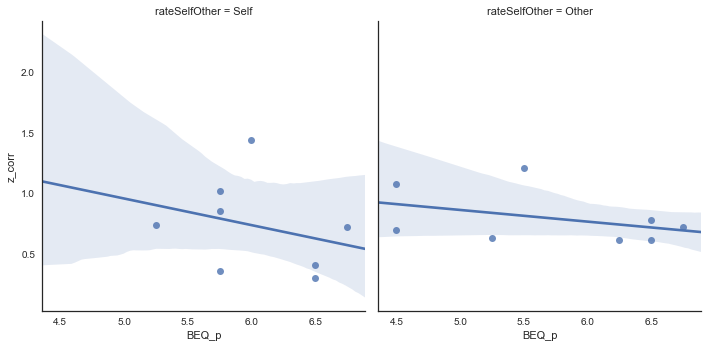

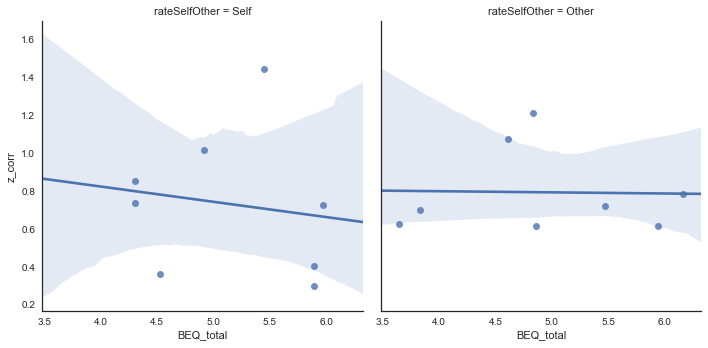

In [107]:
BEQ  = pd.read_csv('/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/BEQ.csv')
BEQ = BEQ.merge(pd.DataFrame(z_correlations, columns=['videoNumber', 'z_corr']))


sns.lmplot('BEQ_n', 'z_corr', col='rateSelfOther',  data=BEQ)
sns.lmplot('BEQ_p', 'z_corr', col='rateSelfOther',data=BEQ)#
sns.lmplot('BEQ_total', 'z_corr', col='rateSelfOther', data=BEQ)

